In [1]:
%matplotlib inline

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz
from scipy.signal import welch, periodogram
from scipy.linalg import eig
import physoce.tseries as ts
import gsw
import lmfit
from scipy.special import ker,kei

In [2]:
ds = xr.open_dataset('data/MBARI_StationM_ADCP_201711_201811.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:    (beam: 4, bin: 23, time: 98208)
Coordinates:
  * time       (time) datetime64[ns] 2017-11-10T10:03:13.760000 ... 2018-10-17T09:58:13.720000
Dimensions without coordinates: beam, bin
Data variables:
    Pit        (time) float64 ...
    Rol        (time) float64 ...
    Hea        (time) float64 ...
    Tem        (time) float64 ...
    Dep        (time) float64 ...
    Ori        (time) int64 ...
    BIT        (time) int64 ...
    Bat        (time) int64 ...
    Eas        (time, bin) float64 ...
    Nor        (time, bin) float64 ...
    Ver        (time, bin) float64 ...
    Err        (time, bin) float64 ...
    EA         (time, bin, beam) float64 ...
    PG         (time, bin, beam) float64 ...
    C          (time, bin, beam) float64 ...
    binheight  (bin) float64 ...
    Eas_tide   (time, bin) float64 ...
    Nor_tide   (time, bin) float64 ...
    Eas_filt   (time, bin) float64 ...
    Nor_filt   (time, bin) float64 ...
Attributes:
    PingsPer

In [4]:
ds['time']

<xarray.DataArray 'time' (time: 98208)>
array(['2017-11-10T10:03:13.760000000', '2017-11-10T10:08:13.760000000',
       '2017-11-10T10:13:13.760000000', ..., '2018-10-17T09:48:13.720000000',
       '2018-10-17T09:53:13.720000000', '2018-10-17T09:58:13.720000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-11-10T10:03:13.760000 ... 2018-10-17T09:58:13.720000

Text(0, 0.5, 'height above instrument [m]')

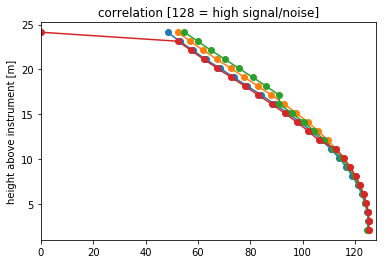

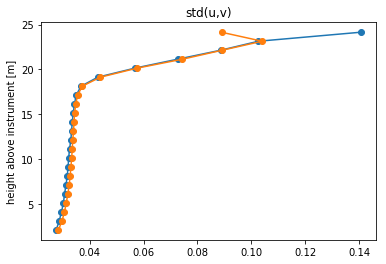

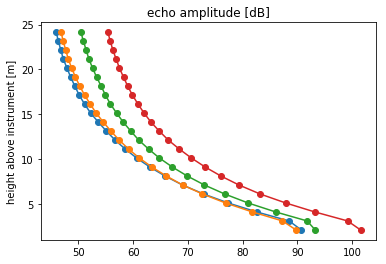

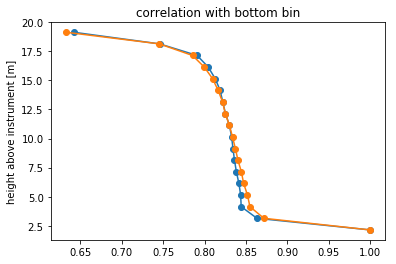

In [5]:
plt.figure()
plt.plot(np.mean(ds['C'],axis=0),ds['binheight'],'-o')
plt.title('correlation [128 = high signal/noise]')
plt.ylabel('height above instrument [m]')
plt.xlim([0,128])

plt.figure()
plt.plot(np.std(ds['Eas'],axis=0),ds['binheight'],'-o')
plt.plot(np.std(ds['Nor'],axis=0),ds['binheight'],'-o')
plt.title('std(u,v)')
plt.ylabel('height above instrument [m]')

plt.figure()
plt.plot(np.mean(ds['EA'],axis=0),ds['binheight'],'-o')
plt.title('echo amplitude [dB]')
plt.ylabel('height above instrument [m]')

plt.figure()
plt.plot(np.corrcoef(ds['Eas'],rowvar=False)[:,0],ds['binheight'],'-o')
plt.plot(np.corrcoef(ds['Nor'],rowvar=False)[:,0],ds['binheight'],'-o')
plt.title('correlation with bottom bin')
plt.ylabel('height above instrument [m]')

Text(0.5, 0, '[m/s]')

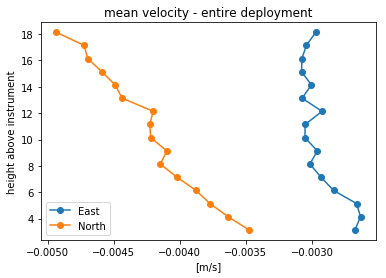

In [6]:
bini = np.arange(1,17)

plt.figure()
plt.plot(np.mean(ds['Eas'][:,bini],axis=0),ds['binheight'][bini],'-o')
plt.plot(np.mean(ds['Nor'][:,bini],axis=0),ds['binheight'][bini],'-o')
plt.title('mean velocity - entire deployment')
plt.legend(['East','North'])
plt.ylabel('height above instrument')
plt.xlabel('[m/s]')

In [7]:
dt = 5*60 # 5 min sample interval (in seconds)

x = cumtrapz(ds['Eas']*dt,axis=0)
y = cumtrapz(ds['Nor']*dt,axis=0)

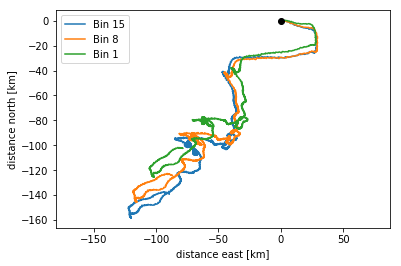

In [8]:
plt.figure()
plt.plot(x[:,15]/1000,y[:,15]/1000)
plt.plot(x[:,7]/1000,y[:,8]/1000)
plt.plot(x[:,1]/1000,y[:,1]/1000)
plt.plot(0,0,'ko')
plt.axis('equal')
plt.xlabel('distance east [km]')
plt.ylabel('distance north [km]')
plt.legend(['Bin 15','Bin 8','Bin 1'])

Text(0.5, 1.0, 'northward velocity')

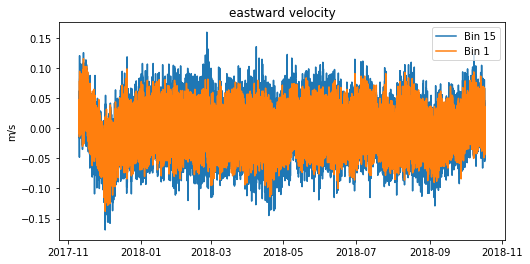

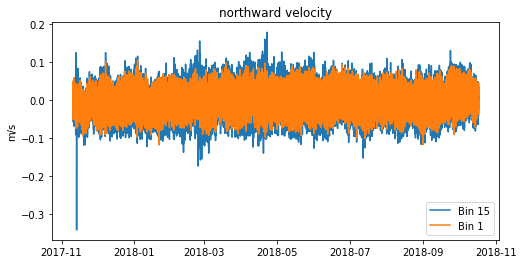

In [13]:
plt.figure(figsize=(8,4))
plt.plot(ds['time'],ds['Eas'][:,15]);
plt.plot(ds['time'],ds['Eas'][:,1]);
plt.legend(['Bin 15','Bin 1'])
plt.ylabel('m/s')
plt.title('eastward velocity')

plt.figure(figsize=(8,4))
plt.plot(ds['time'],ds['Nor'][:,15]);
plt.plot(ds['time'],ds['Nor'][:,1]);
plt.legend(['Bin 15','Bin 1'])
plt.ylabel('m/s')
plt.title('northward velocity')

Text(0.5, 1.0, 'northward velocity')

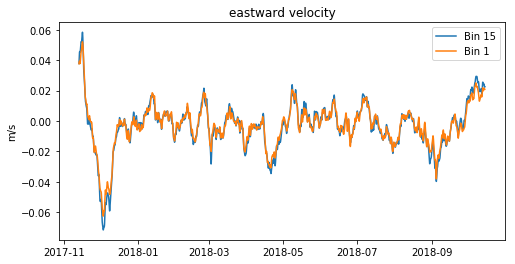

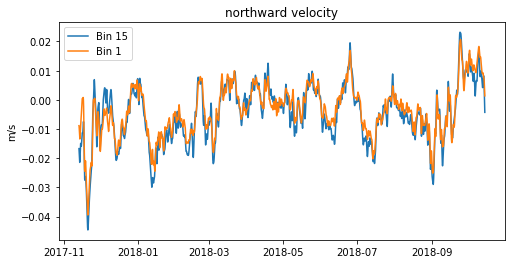

In [10]:
plt.figure(figsize=(8,4))
plt.plot(ds['time'],ds['Eas_filt'][:,15]);
plt.plot(ds['time'],ds['Eas_filt'][:,1]);
plt.legend(['Bin 15','Bin 1'])
plt.ylabel('m/s')
plt.title('eastward velocity')

plt.figure(figsize=(8,4))
plt.plot(ds['time'],ds['Nor_filt'][:,15]);
plt.plot(ds['time'],ds['Nor_filt'][:,1]);
plt.legend(['Bin 15','Bin 1'])
plt.ylabel('m/s')
plt.title('northward velocity')

Text(0.5, 1.0, 'Station M - low pass filtered velocity - bin 15')

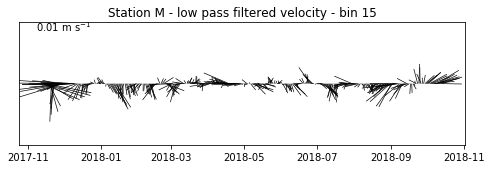

In [11]:
from graph import stick_plot



fig, ax = plt.subplots(figsize=(8, 2.25))

q = stick_plot(np.array(ds['time'])[::288],
               np.array(ds['Eas_filt'])[::288,15],
               np.array(ds['Nor_filt'])[::288,15],
               ax=ax,width=0.0015)

ref = 0.01
qk = plt.quiverkey(q, 0.1, 0.85, ref,
                  "%s m s$^{-1}$" % ref,
                  labelpos='N', coordinates='axes')
_ = plt.xticks(rotation=0)

plt.title('Station M - low pass filtered velocity - bin 15')

Text(0.5, 1.0, 'full velocity, 2018-02-01-2018-02-15, bin 15')

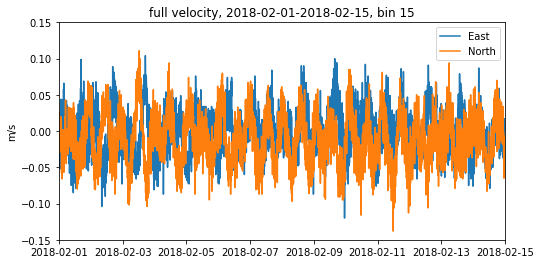

In [12]:
t1=np.datetime64('2018-02-01')
t2=np.datetime64('2018-02-15')

plt.figure(figsize=(8,4))
plt.plot(ds['time'],ds['Eas'][:,15]);
plt.plot(ds['time'],ds['Nor'][:,15]);
plt.ylabel('m/s')
plt.xlim([t1,t2])
plt.ylim([-0.15,0.15])
plt.legend(['East','North'])
plt.title('full velocity, '+str(t1)+'-'+str(t2)+', bin 15')

Text(0.5, 1.0, 'detided velocity, 2018-02-01-2018-02-15, bin 15')

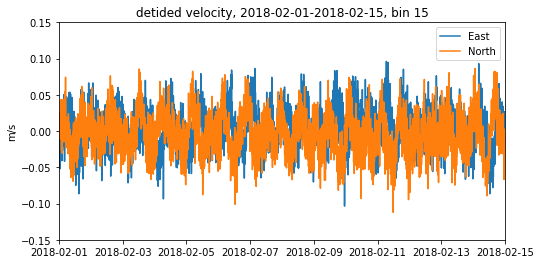

In [13]:
t1=np.datetime64('2018-02-01')
t2=np.datetime64('2018-02-15')

plt.figure(figsize=(8,4))
plt.plot(ds['time'],ds['Eas'][:,15]-ds['Eas_tide'][:,15]);
plt.plot(ds['time'],ds['Nor'][:,15]-ds['Nor_tide'][:,15]);
plt.legend(['Bin 15','Bin 1'])
plt.ylabel('m/s')
plt.ylim([-0.15,0.15])
plt.xlim([t1,t2])
plt.legend(['East','North'])
plt.title('detided velocity, '+str(t1)+'-'+str(t2)+', bin 15')

In [14]:
Eas = np.array(ds['Eas'])
Nor = np.array(ds['Nor'])
Eas_tide = np.array(ds['Eas_tide'])
Nor_tide = np.array(ds['Nor_tide'])

N = len(Eas)
fE,SE = welch(Eas[:,5],fs=288.,nperseg=N/6,window='hanning')
fN,SN = welch(Nor[:,5],fs=288.,nperseg=N/6,window='hanning')

#rotary spectrum
fr,Sr = welch(Eas[:,0]+1j*Nor[:,0],
              fs=288.,nperseg=N/6,
              window='hann',return_onesided=False)
icw, = np.where(fr<0)
iccw, = np.where(fr>0)
fcw = -fr[icw]
Scw = Sr[icw]
fccw = fr[iccw]
Sccw = Sr[iccw]

In [15]:
fcw[1:]

array([1.43982405e+02, 1.43964809e+02, 1.43947214e+02, ...,
       5.27859238e-02, 3.51906158e-02, 1.75953079e-02])

In [16]:
fccw[::-1]

array([1.43982405e+02, 1.43964809e+02, 1.43947214e+02, ...,
       5.27859238e-02, 3.51906158e-02, 1.75953079e-02])

In [17]:
# rotary coefficient
Cr = np.abs(Scw[1:]-Sccw[::-1])/(Scw[1:]+Sccw[::-1])
fr = fcw[1:]

In [18]:
f_cpd = gsw.f(35+8.4585/60)*86400/(2*np.pi)

# theoretical prediction (Van Haren and Millot (2004), eq. 11)
sigmar = 2*np.pi*fr
Cr_pred = 2*sigmar*(2*np.pi*f_cpd)/(sigmar**2 + (2*np.pi*f_cpd)**2)

Text(0.5, 1.0, 'rotary spectra')

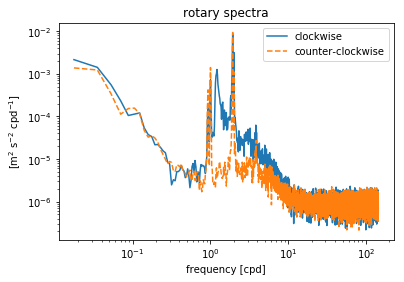

In [ ]:
plt.figure()
plt.loglog(fcw,Scw)
plt.loglog(fccw,Sccw,'--')
plt.legend(['clockwise','counter-clockwise'])
plt.xlabel('frequency [cpd]')
plt.ylabel('[m$^2$ s$^{-2}$ cpd$^{-1}$]')
plt.title('rotary spectra')

Text(0.9295120061967467, 0.01597311802948467, '$O_1$')

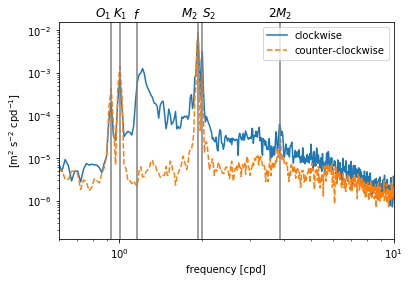

In [ ]:
plt.figure()
plt.loglog(fcw,Scw)
plt.loglog(fccw,Sccw,'--')
plt.legend(['clockwise','counter-clockwise'])
plt.xlabel('frequency [cpd]')
plt.ylabel('[m$^2$ s$^{-2}$ cpd$^{-1}$]')

yl = plt.ylim()
plt.plot([f_cpd,f_cpd],yl,'-',color='gray')
plt.plot([24/25.82,24/25.82],yl,'-',color='gray')
plt.plot([24/23.93,24/23.93],yl,'-',color='gray')
plt.plot([2,2],yl,'-',color='gray')
plt.plot([24/12.42,24/12.42],yl,'-',color='gray')
plt.plot([24/12.42*2,24/12.42*2],yl,'-',color='gray')
plt.ylim(yl)
plt.xlim([0.6,10])

plt.text(f_cpd,yl[1],'$f$',fontsize=12,
         horizontalalignment='center',
         verticalalignment='bottom')
plt.text(24/12.42,yl[1],'$M_2$',fontsize=12,
         horizontalalignment='right',
         verticalalignment='bottom')
plt.text(24/12.42*2,yl[1],'$2M_2$',fontsize=12,
         horizontalalignment='center',
         verticalalignment='bottom')
plt.text(2,yl[1],'$S_2$',fontsize=12,
         horizontalalignment='left',
         verticalalignment='bottom')
plt.text(24/23.93,yl[1],'$K_1$',fontsize=12,
         horizontalalignment='center',
         verticalalignment='bottom')
plt.text(24/25.82,yl[1],'$O_1$',fontsize=12,
         horizontalalignment='right',
         verticalalignment='bottom')

(0, 1)

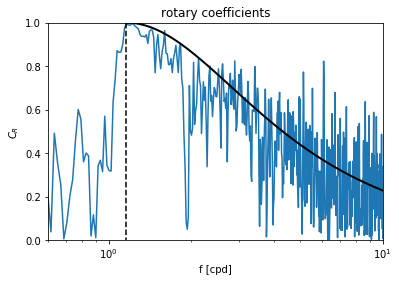

In [ ]:
iwi, = np.where(fr >= f_cpd)

plt.figure()
plt.semilogx(fr,Cr)
plt.semilogx(fr[iwi],Cr_pred[iwi],'k-',lw=2)
yl = plt.ylim()
plt.semilogx([f_cpd,f_cpd],yl,'k--')
plt.xlabel('f [cpd]')
plt.ylabel('$C_R$')
plt.title('rotary coefficients')
plt.ylim(yl)
plt.xlim([0.6,10])
plt.ylim([0,1])

In [ ]:
ds['height'] = ds['binheight'] + 0.4572 # add instrument height (18 inches)
zi = np.arange(0,len(ds['height'])-7)

w = np.array(ds['Eas_filt'][:,zi])+1j*np.array(ds['Nor_filt'][:,zi])
fi, = np.where(np.isfinite(np.real(w[:,0])))

In [ ]:
C = np.cov(w[fi,:],rowvar=False)

In [ ]:
val,vec = eig(C)

In [ ]:
val

array([5.15417556e-03+9.53580040e-21j, 8.51256795e-06-2.48490750e-21j,
       2.58853835e-06-1.19654865e-20j, 2.14451665e-06+1.27244115e-20j,
       1.88947730e-06-1.03794784e-20j, 8.32212347e-07+8.54784780e-21j,
       9.16121288e-07-4.54628061e-20j, 1.72671258e-06-2.74881425e-20j,
       1.68640090e-06-1.43491813e-20j, 1.60193301e-06-1.65211813e-20j,
       1.48900075e-06+1.11970405e-20j, 1.40776195e-06+1.09346977e-20j,
       1.09773746e-06+4.17976705e-20j, 1.04493510e-06+2.92807105e-20j,
       1.24375257e-06-1.83672643e-20j, 1.21532991e-06+1.79974807e-20j])

In [ ]:
np.abs(val)/np.sum(np.abs(val))

array([9.94328815e-01, 1.64222028e-03, 4.99373419e-04, 4.13714022e-04,
       3.64512559e-04, 1.60548027e-04, 1.76735500e-04, 3.33112456e-04,
       3.25335640e-04, 3.09040336e-04, 2.87253768e-04, 2.71581412e-04,
       2.11772372e-04, 2.01585892e-04, 2.39941191e-04, 2.34457973e-04])

In [ ]:
vec[:,0]

array([0.21547246+0.03027987j, 0.22815629+0.02756145j,
       0.23612105+0.02342527j, 0.24346814+0.01992399j,
       0.24656102+0.01728033j, 0.25059411+0.01420538j,
       0.25377798+0.01151062j, 0.25539795+0.00832762j,
       0.25594702+0.00787283j, 0.25669189+0.0048134j ,
       0.25778151+0.00377672j, 0.25660757+0.00286417j,
       0.25764929+0.00023888j, 0.2588712 +0.j        ,
       0.2568699 -0.00116901j, 0.25835882-0.00214193j])

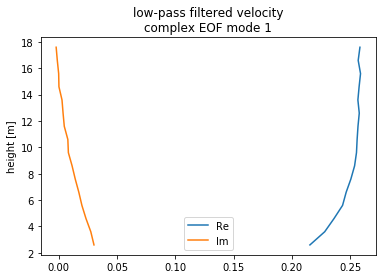

In [ ]:
plt.figure()
plt.plot(np.real(vec[:,0]),ds['height'][zi])
plt.plot(np.imag(vec[:,0]),ds['height'][zi])
plt.title('low-pass filtered velocity\ncomplex EOF mode 1')
plt.ylabel('height [m]')
plt.legend(['Re','Im'])

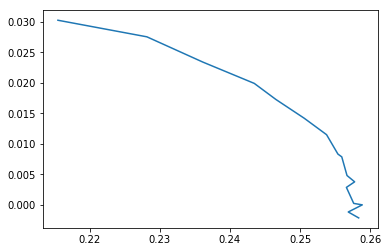

In [ ]:
plt.figure()
plt.plot(np.real(vec[:,0]),np.imag(vec[:,0]))

### To Do:

Fit steady Ekman model to low-pass filtered currents at each time step, estimate ustar and zo, treat upper layer currents as free parameters

Treat zo as constant, determine what value of zo gives best fit to data

Smith and McLean (1977) - Sediment stratification, effect of large scale dunes at upper levels - possible explanations for large zo

Note large zo in Edwards CEOF paper

In [ ]:
def planetary_bbl_structure(ustar,zo,z,f):
    '''
    Calculate vertical structure of a planetary boundary layer (a.k.a.
    bottom Ekman layer) following Soulsby (1983). The calculation assumes
    that the eddy viscosity increases linearly with height.
    '''

    i = 1j 
    kappa = 0.41 # Von Karman's constant
    
    # non-dimensional height and roughness length
    xi = 2*np.sqrt(f*z/(kappa*ustar))
    xio = 2*np.sqrt(f*zo/(kappa*ustar))
    
    # Q/Qinf in Equation 31 of Soulsby (1983)
    fac = (1-(ker(xi)*ker(xio) + kei(xi)*kei(xio))/
             (ker(xio)**2 + kei(xio)**2) + 
           i*(ker(xi)*kei(xio) - kei(xi)*ker(xio))/
             (ker(xio)**2 + kei(xio)**2))

    return fac

def rotating_planetary_bbl(ustar,zo,Qinf,z,f,zoffset=0):
    Q = Qinf*planetary_bbl_structure(ustar,zo,z,f)

    return Q

In [ ]:
def fit_function(params, z=None, dat=None):
    
    Q = rotating_planetary_bbl(params['ustar'],
                                      params['zo'],
                                      params['Qinf_real']+1j*params['Qinf_imag'],
                                      z+params['z_offset'],
                                      params['f'])

    resid1 = np.abs(np.real(dat) - np.real(Q))
    resid2 = np.abs(np.imag(dat) - np.imag(Q))    
    
    return np.concatenate((resid1, resid2))

In [ ]:
# select good data and decimate to every six hours (6*12 = 72 data points)
gi, = np.where(np.isfinite(ds['Eas_filt'][:,0]))
u = np.array(ds['Eas_filt'][gi,zi][::72,:])
v = np.array(ds['Nor_filt'][gi,zi][::72,:])
t = np.array(ds['time'][gi][::72])
w = u+1j*v

In [ ]:
f = gsw.f(35+8.4585/60)

params = lmfit.Parameters()
params.add('f', value=f, vary=False)
params.add('zo', value=0.01,vary=True)
params.add('ustar', value=0.001,vary=True)
params.add('z_offset', value=1e-16,vary=False)  # acccount for unknowns in measurement levels
params.add('Qinf_real', value=1e-16,vary=False)
params.add('Qinf_imag', value=1e-16,vary=False)

In [ ]:
dat_z = np.array(ds['height'][zi])

zo_fit = np.nan*np.zeros(len(w))
ustar_fit = np.nan*np.zeros(len(w))
zo_stderr = np.nan*np.zeros(len(w))
ustar_stderr = np.nan*np.zeros(len(w))
Qinf_fit = np.nan*np.zeros(len(w))+1j*np.nan*np.zeros(len(w))

for ti in np.arange(len(w)):
    dat = w[ti,:]

    try:
        params.add('Qinf_real', value=np.real(dat[zi[-1]]),vary=True)
        params.add('Qinf_imag', value=np.imag(dat[zi[-1]]),vary=True)
    
        out = lmfit.minimize(fit_function, params, args=(dat_z, dat),nan_policy='omit')
    except:
        pass
    
    zo_fit[ti] = out.params['zo'].value
    zo_stderr[ti] = out.params['zo'].stderr
    ustar_fit[ti] = out.params['ustar'].value
    ustar_stderr[ti] = out.params['ustar'].stderr
    Qinf_fit[ti] = out.params['Qinf_real'].value + 1j*out.params['Qinf_imag'].value   

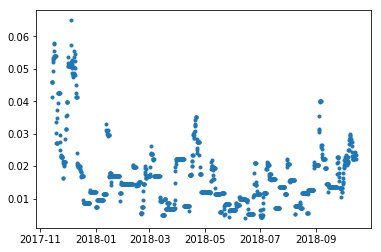

In [ ]:
plt.figure()
plt.plot(t,np.abs(Qinf_fit),'.')

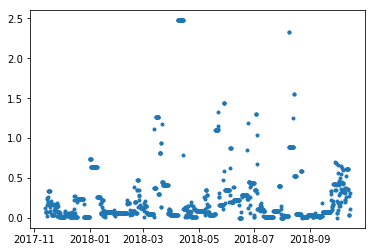

In [ ]:
plt.figure()
plt.plot(t,zo_fit,'.')

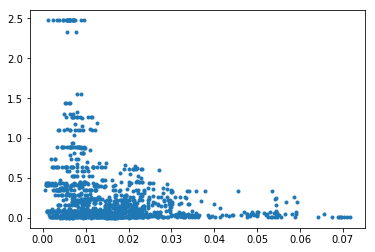

In [ ]:
plt.figure()
plt.plot(np.abs(w[:,zi[-1]]),zo_fit,'.')

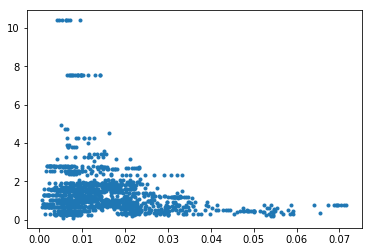

In [ ]:
plt.figure()
plt.plot(np.abs(w[:,zi[-1]]),zo_stderr/zo_fit,'.')

0.08431034869405069


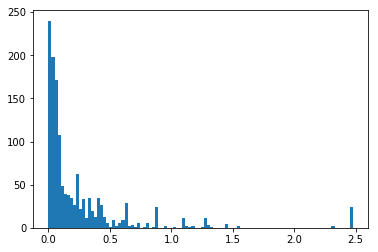

In [ ]:
print(np.median(zo_fit))

plt.figure()
plt.hist(zo_fit,100);

In [ ]:
paramsb = lmfit.Parameters()
paramsb.add('f', value=f, vary=False)
paramsb.add('zo',vary=False)
paramsb.add('ustar', value=0.001,vary=True)
paramsb.add('z_offset', value=1e-16,vary=False)  # acccount for unknowns in measurement levels
paramsb.add('Qinf_real', value=1e-16,vary=True)
paramsb.add('Qinf_imag', value=1e-16,vary=True)

In [ ]:
zo_array = np.logspace(-4,np.log10(0.3))

ustar_fit_b = np.nan*np.zeros([len(w),len(zo_array)])
ustar_stderr_b = np.nan*np.zeros([len(w),len(zo_array)])
Qinf_fit_b = np.nan*np.zeros([len(w),len(zo_array)]) + 1j*np.nan*np.zeros([len(w),len(zo_array)])
resid_b = np.nan*np.zeros([len(w),len(zo_array)])

print('loop through zo values...')
for zfi,zo_val in enumerate(zo_array):
    if zfi % 10 == 0:
        print('zo=',zo_val)
    paramsb.add('zo',zo_val,vary=False)
    for ti in np.arange(len(w)):
        dat = w[ti,:]

        try:
            paramsb.add('Qinf_real', value=np.real(dat[zi[-1]]),vary=True)
            paramsb.add('Qinf_imag', value=np.imag(dat[zi[-1]]),vary=True)

            out = lmfit.minimize(fit_function, paramsb, args=(dat_z, dat),nan_policy='omit')
        except:
            pass

        ustar_fit_b[ti,zfi] = out.params['ustar'].value
        ustar_stderr_b[ti,zfi] = out.params['ustar'].stderr
        resid_b[ti,zfi] = np.sum(out.residual)
        Qinf_fit_b[ti,zfi] = out.params['Qinf_real'].value + 1j*out.params['Qinf_imag'].value   

loop through zo values...
zo= 0.0001


In [ ]:
out.params

In [ ]:
bigi, = np.where(np.abs(w[:,0]) > 0.03)

In [ ]:
bi = np.argmin(np.mean(resid_b[bigi,:],axis=0))

In [ ]:
gi, = np.where(ustar_stderr_b[:,bi]/ustar_fit_b[:,bi] < 1)

In [ ]:
plt.figure()
plt.plot(np.abs(w[gi,0]),ustar_fit_b[gi,bi],'.');

In [ ]:
plt.figure(figsize=(9,4))

plt.subplot(121)
h1 = plt.semilogy(np.abs(w[:,0]),ustar_stderr_b/ustar_fit_b,'.',color='gray');
h2 = plt.semilogy(np.abs(w[:,0]),ustar_stderr_b[:,bi]/ustar_fit_b[:,bi],'k.');
plt.xlabel('current speed [m/s]')
plt.ylabel('relative error SE$_{u_*}$/$u_*$')
plt.title('friction velocity - relative error in fit')
plt.ylim([0,1e6])
plt.legend([h2[0],h1[0]],['$z_o$ = 0.03 m','all $z_o$'])

plt.subplot(122)
plt.plot(zo_array,np.mean(resid_b[bigi,:],axis=0)/len(zi),'k-o')
plt.xlabel('$z_o$ [m]')
plt.ylabel('mean residual [m/s]')
plt.title('residual of fit (speed > 0.03 m/s)')

plt.tight_layout()
plt.savefig('figures_paper/nonlinear_fit_stats.png',dpi=600)
plt.savefig('figures_paper/nonlinear_fit_stats.pdf')

In [ ]:
plt.figure(figsize=(4.5,4.5))

plt.subplot(211)
plt.plot(np.abs(w[:,0]),ustar_stderr_b[:,bi]/ustar_fit_b[:,bi],'k.');
plt.ylim([0,10])
plt.xlabel('current speed [m/s]')
plt.ylabel('relative error SE$_{u_*}$/$u_*$')
plt.title('friction velocity - relative error in fit')

plt.subplot(212)
plt.plot(zo_array,np.mean(resid_b[bigi,:],axis=0),'-o')

In [ ]:
plt.figure()
plt.plot(t[bigi],ustar_fit_b[bigi,bi],'.')

In [ ]:
plt.figure()
plt.plot(zo_array,np.mean(resid_b[bigi,:],axis=0),'-o')

In [ ]:
fac = 0.23

plt.figure()
plt.plot(np.real(vec[:,0])*fac,ds['height'][zi],'s')
plt.plot(np.imag(vec[:,0])*fac,ds['height'][zi],'s')
plt.title('low-pass filtered velocity\ncomplex EOF mode 1')
plt.ylabel('height [m]')
plt.legend(['Re','Im'])

In [ ]:
zplt = np.arange(out.params['zo'],20,0.05)

fac1 = 0.23
dat = vec[:,0]*fac
paramsb.add('zo', value=0.03,vary=False)
paramsb.add('ustar', value=0.001,vary=True)
paramsb.add('Qinf_real', value=0.05,vary=True)
paramsb.add('Qinf_imag', value=0.0,vary=True)
out = lmfit.minimize(fit_function, paramsb, args=(dat_z, dat),nan_policy='omit')
paramsb.add('zo', value=0.002,vary=False)
paramsb.add('ustar', value=0.001,vary=True)
paramsb.add('Qinf_real', value=0.05,vary=True)
paramsb.add('Qinf_imag', value=0.0,vary=True)
out2 = lmfit.minimize(fit_function, paramsb, args=(dat_z, dat),nan_policy='omit')

fac3 = 0.23/1.5
dat = vec[:,0]*fac3
paramsb.add('zo', value=0.03,vary=False)
paramsb.add('ustar', value=0.001,vary=True)
paramsb.add('Qinf_real', value=0.05,vary=True)
paramsb.add('Qinf_imag', value=0.0,vary=True)
out3 = lmfit.minimize(fit_function, paramsb, args=(dat_z, dat),nan_policy='omit')
Q1 = rotating_planetary_bbl(out.params['ustar'],out.params['zo'],
                           out.params['Qinf_real'] + 1j*out.params['Qinf_imag'],
                           zplt,out.params['f'])
Q2 = rotating_planetary_bbl(out2.params['ustar'],out2.params['zo'],
                           out2.params['Qinf_real'] + 1j*out2.params['Qinf_imag'],
                           zplt,out2.params['f'])
Q3 = rotating_planetary_bbl(out3.params['ustar'],out3.params['zo'],
                           out3.params['Qinf_real'] + 1j*out3.params['Qinf_imag'],
                           zplt,out3.params['f'])

In [ ]:
plt.figure(figsize=(4.5,6))

plt.plot(np.real(vec[:,0])*fac1/1.5,ds['height'][zi],'ks')
plt.plot(np.imag(vec[:,0])*fac1/1.5,ds['height'][zi],'s',color='gray')
plt.plot(np.real(Q3),zplt,'k-')
plt.plot(np.imag(Q3),zplt,'-',color='gray')
# plt.plot(np.real(vec[:,0])*fac3,ds['height'][zi],'ko')
# plt.plot(np.imag(vec[:,0])*fac3,ds['height'][zi],'o',color='gray')
# plt.plot(np.real(Q3),zplt,'k--')
# plt.plot(np.imag(Q3),zplt,'--',color='gray')
plt.title('complex PCA mode 1\n& planetary boundary layer model')
plt.ylabel('height [m]')
plt.legend(['complex PCA - Real','complex PCA - Imag','PBL model - Real','PBL model - Imag'])
plt.ylim([0,20])
#plt.xlim([-0.005,0.07])
plt.xlabel('[m/s]')

plt.tight_layout()
plt.savefig('figures_paper/pbl_ceof_profiles.png',dpi=600)
plt.savefig('figures_paper/pbl_ceof_profiles.pdf')

In [ ]:
out3

In [ ]:
out

In [ ]:
plt.figure(figsize=(4.5,6))

plt.semilogy(np.real(vec[:,0])*fac1/1.5,ds['height'][zi],'ks')
plt.semilogy(np.imag(vec[:,0])*fac1/1.5,ds['height'][zi],'s',color='gray')
plt.semilogy(np.real(Q3),zplt,'k-')
plt.semilogy(np.imag(Q3),zplt,'-',color='gray')
# plt.plot(np.real(vec[:,0])*fac3,ds['height'][zi],'ko')
# plt.plot(np.imag(vec[:,0])*fac3,ds['height'][zi],'o',color='gray')
# plt.plot(np.real(Q3),zplt,'k--')
# plt.plot(np.imag(Q3),zplt,'--',color='gray')
plt.title('complex EOF mode 1\n& planetary boundary layer model')
plt.ylabel('height [m]')
plt.legend(['CEOF - Real','CEOF - Imag','PBL model - Real','PBL model - Imag'],loc=(0.4,0.8))
plt.ylim([0,20])
#plt.xlim([-0.005,0.07])
plt.xlabel('[m/s]')